<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 
# Lesson: PyMC & Bayesian Regression

_Authors: Tim Book, Matt Brems, Noelle Brown_

## LEARNING OBJECTIVES
By the end of the lesson, students should be able to:
- Define conjugacy.
- Fit models in PyMC.
- Interpret traceplots, posterior distributions, and posterior predictions.

---

## Recap
Remember that parameters have distributions. In Bayesian statistics, our goal is to **find the posterior distribution of our parameter of interest**.

<details><summary>In order to generate a posterior distribution, what are the two components we need?</summary>

- Prior distribution summarizing our beliefs about the parameter before observing any data.
- Likelihood function summarizing how our data were generated.
</details>

## Why Bayes?
There are several reasons why we would prefer to use a Bayesian technique over a frequentist one. What are they? (THREAD)

<details>
    <summary>What are some reasons to use Bayesian techniques?</summary>
    
* When you have prior knowledge of a situation (ie, you might know better than data suggests)
* When you have small data that can benefit from additional subject matter expertise
* When you want to be able to make advanced probabilistic statements that are unavailable to frequentist techniques
</details>

In [1]:
# Install pymc3
# !pip install pymc3

In [12]:
# Import the necessary packages:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import pymc3 as pm

## Example 1: Skittles!
In a snack-size pack of Skittles, you are concerned with getting an unfair amount of green Skittles (the worst flavor). You think there are about 20 skittles per pack. There are 5 different colors of Skittles. 

<img src="../images/skittles.jpeg" style="height: 300px"> 

How can we determine if we get an unfair amount of green Skittles?

**A frequentist would...**
- Open many snack-size packs of Skittles, and estimate $\hat{p}$, the probability of getting a green skittle.
- Conduct a hypothesis test to determine if $p = 0.2$.

**A Bayesian would...**
- Begin with a preconceived notion about $p$ (a prior). This prior reflects not just our belief, but the strength of our belief.
- Open many snack-size packs of Skittles and record the results (the likelihood).
- Obtain a posterior distribution for $p$ that combines our priors with our data.
- Make statements about this posterior.

What is the (posterior) distribution of the number of green skittles I might find in a pack?

In [13]:
# Suspend your disbelief and pretend we only have data on the number of
# green Skittles in packs, but NOT the total number of Skittles in said packs.
skits = pd.read_csv("../datasets/skittles.csv")
skits.head()

,n_greens
0,7
1,10
2,7
3,2
4,8


In [14]:
skits.shape

(20, 1)

### Step 1: Define our likelihood and priors

We'll start with our priors. 

What do we know/believe about the percentage of green skittles we might find in a pack? 

<details><summary>What distribution will be best for this?</summary>

- The percentage of green skittles we might find in a pack is a number between 0 and 1.
- The Beta distribution will be good here!
</details>

#### The Beta Distribution
Recall that the beta distribution is a **continuous** distribution. It's often used in Bayesian statistics because it's one of the only continuous distributions that take values between 0 and 1. This makes it particularly convenient to use as a prior on probabilities.

You can take a closer look at the Beta distribution [here](https://en.wikipedia.org/wiki/Beta_distribution)!

If $X \sim \text{Beta}(a, b)$, then

* $\text{E}[X] = \frac{a}{a + b}$
* $\text{Var}[X] = \frac{ab}{(a + b)^2(a + b + 1)}$

Also note: The $\text{Beta}(1, 1)$ distribution is actually the $\text{Uniform}(0, 1)$ distrubtion!

Let's compute some beta means and variances. What do you think is a reasonable prior for our problem?

<details><summary>In my opinion, setting up your priors and likelihoods is the hardest part of Bayesian inference.</summary>

![](../images/modified_bayes.png)

</details>

In [15]:
def beta_stats(a, b):
    mean_ = a / (a + b)
    var_ = a*b / ((a + b)**2 * (a + b + 1))
    std_ = var_**.5
    return mean_, std_

In [16]:
# We want the mean to be about 0.2 (20% of each flavor)
beta_stats(4, 16)

(0.2, 0.08728715609439695)

In [17]:
# Prior for percentage of green skittles we might find in a pack
# p ~ Beta(4, 16)

<details><summary>We can also set a prior on the number of Skittles that are in a pack! What distribution will be best for this?</summary>

- The number of Skittles in each pack is count data.
- The Poisson distribution will work well here!
</details>

In [18]:
# Prior for number of Skittles in a pack
# N ~ Poisson(20)

Now, let's define our likelihood. 

We are interested in seeing how many green Skittles are in a bag.

There's a fixed number of Skittles in a bag. Each of those Skittles has some probability of being green or not green.
We are looking to see if a Skittle is green or not in our bag. 

A good tip from [Bayesian Methods for Hackers:](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb)  
> "A good starting thought to Bayesian modeling is to think about how your data might have been generated. Position yourself in an omniscient position, and try to imagine how you would recreate the dataset."

<details><summary>What distribution will be best for this?</summary>

- Each Skittle has some probability of being green and some probability of being not green.
- The Binomial distribution will work here.
</details>

In [19]:
# Likelihood
# X ~ Binomial(Number of skittles, probability of green)

In [20]:
# Priors:
# N ~ Poisson(20)
# p ~ Beta(4, 16) 

# Likelihood
# X ~ Binomial(Number of skittles, prob of green)

### MCMC Using PyMC3
Markov chain Monte Carlo methods (commonly abbreviated MCMC methods) made conjugacy mostly unnecessary.

![](./images/pymc3-res.png)

[TL;DR](https://en.wikipedia.org/wiki/TL;DR) of MCMC: We use computers to take our prior and likelihood, then simulate a large number of samples from the posterior.
- If I want to find the mean of my posterior distribution, then I can just do `np.mean(xs)`, where `xs` is my saved list of samples from my posterior.
- If I want to find the median of my posterior distribution, then I can do `np.median(xs)`.
- If I want to find the 95% [credible interval](http://www.statisticshowto.com/credible-interval/) for my parameter based on the posterior distribution of my parameter, then I can just find the 2.5th and 97.5th percentiles of `xs`!

Today, we're going to use `PyMC3`, a Bayesian modeling library in Python that will enable us to use Markov chain Monte Carlo methods. Luckily, this is a package that is geared toward scientists, not necessarily statisticians. We'll be able to use what we currently know about Bayesian statistics to leverage this *really* powerful library.

### The Situation:
$$
\begin{align}
    X | p &\sim \text{Binomial}(n, p) \\
        p &\sim \text{Beta}(a, b)
\end{align}
$$

We've also observed a certain number of greens in our 20 bags (our data).

### PyMC3 models live in "contexts" instead of "objects"
That means they'll look something like this:

```python
with pm.Model() as model:
    # Define priors
    # Define likelihood
    # Execute MCMC
```

### Step 2: Let's set this up in PyMC3!

In [21]:
# Use PyMC3 to solve for the posterior distribution
with pm.Model() as model:
    # Priors
    N = pm.Poisson("N", 20) # N - the number of skittles in a bag
    p = pm.Beta("p", 4, 16) # p - probability of getting a green skittle
    # Likelihood
    X = pm.Binomial("X", N, p, observed=skits["n_greens"])
    # execute
    trace = pm.sample(10_000)

C:\Users\Andrew\AppData\Local\Temp/ipykernel_8080/3946790732.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10_000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [N]
>NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 48 seconds.
The number of effective samples is smaller than 10% for some parameters.


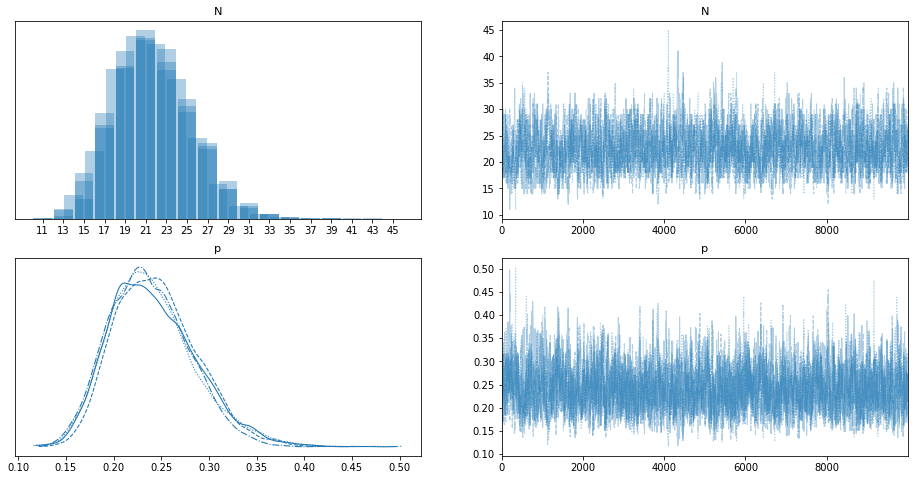

In [22]:
# Visualize the output
with model:
    pm.plot_trace(trace, figsize=(16,8));

In [23]:
# Expected mean that an individual skittle will be grean
trace['p'].mean()

0.24120299169909082

In [24]:
# 95% confidence interval
np.quantile(trace['p'], [0.025, 0.975])

array([0.16646148, 0.33831707])

In [25]:
# An array with expected number of skittles in a bag
trace['N']

array([24, 24, 24, ..., 22, 24, 24], dtype=int64)

In [26]:
# expected amount of green skittles is number of skittles in bag * prob of green
mean_green = trace['N'] * trace['p']
mean_green # An array of number of green skittles

array([4.42001371, 5.13243201, 4.9979731 , ..., 4.96833229, 5.41999886,
       5.39661286])

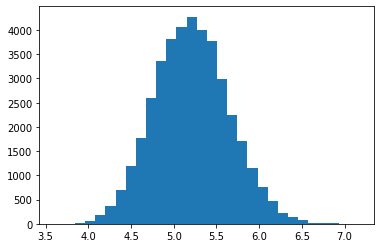

In [27]:
# Plot the average number of green skittles
plt.hist(mean_green, bins=30);

In [28]:
(mean_green <= 6) & (mean_green >= 5)

array([False,  True, False, ..., False,  True,  True])

In [29]:
# What's the probability we will get an expected value of between 5 and 6 green skittles?
np.mean(
    (mean_green <= 6) & (mean_green >= 5)
)

0.63545

## Example 2: Election Day

Let's review the election example from the other day using polling data from [FiveThirtyEight](https://projects.fivethirtyeight.com/2020-election-forecast/). This time, we will look at the probability that Trump wins.

Reminder: our polls gave us the following totals:

```python
n_biden = 7_616 # number of successes
n_surveys = 14_995 # number of trials
```

In [30]:
# Here are the results of our polls.
# 1 = Trump led the poll
# 0 = Biden led the poll
polls = np.array([1]*7379 + [0]*7616)

### Step 1: Establish our priors and our likelihood

Here we are looking for the percentage of votes Trump is likely to win in the election.

An important thing to note is that there is no such thing as sample data for problems like this, since elections only ever happen once. This is why pollsters conduct polls - to gather information about what will _probably_ happen in the future. Polls aren't perfect though, and they also change over time. **We know through personal experience that most elections end up being very close to 50/50.**

We can use the Beta distribution for our prior. We need a mean of .5 (because we expect the election to be 50/50).

_Hint:_ The priors are as subjective as they can get here.

In [31]:
beta_stats(5, 5)

(0.5, 0.15075567228888181)

In [32]:
# Prior
# p ~ Beta(5, 5)

# I can even set this up with even more uncertainty:
# p ~ Beta(a, b)
# a ~ Exp(5)
# b ~ Exp(5)

In [33]:
# Likelihood
# X ~ Bernoulli(p)
# OR: X ~ Binomial(number of trials, probability of success)
# X ~ Binomial(1, p)

### Step 2: Set up the PyMC3 model!

In [34]:
# PyMC3 model
with pm.Model() as model:
    a = pm.Exponential("alpha", lam=1/5)
    b = pm.Exponential("beta", lam=1/5)
    p = pm.Beta("p", a, b)
    X = pm.Binomial("X", 1, p, observed=polls)
    trace = pm.sample(10000)

C:\Users\Andrew\AppData\Local\Temp/ipykernel_8080/1737020000.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 70 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


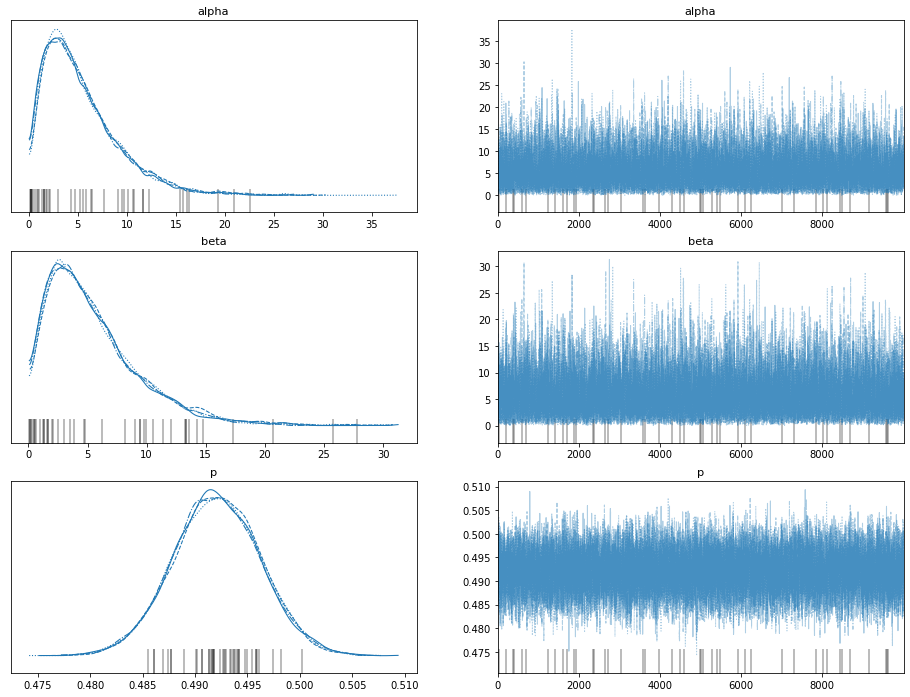

In [35]:
# Traceplot
with model:
    pm.plot_trace(trace, figsize=(16,12));

In [36]:
# Expected value
trace['p'].mean()

0.49206902655536394

In [37]:
# Expected value that Trump will get more than 50% of the votes
np.mean(trace["p"] > 0.5)

0.028175

Remember that we didn't take any outside factors into account (which FiveThirtyEight does) or even talk about the electoral college. Read more about FiveThirtyEight's modeling [here](https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/).

## Example 3: Bayesian Regression for Pay Equity
It is an often-recited statistic that women are paid about 77 cents per dollar a man makes for equal work. But how is this number (and others like it) calculated? We actually conduct a log-regression based on a person's legitimate skill level (ie, things such as education or years of experience that may legitimately contribute to you being paid more) and an indicator for the protected class. For example:

$$ \log W = \beta_0 + \beta_1\text{skill} + \beta_2\text{class} $$

After exponentiating both sides:

$$ W = e^{\beta_0 + \beta_1\text{skill}}e^{\beta_2\text{class}} $$

Where $e^{\beta_2\text{class}}$ simplifies to:

* $e^{\beta_2}$ if you are the (potentially) discriminated class.
* $e^0 = 1$ if you are not the (potentially) discriminated class.

Thus, given a dataset of salaries at a company, we might seek to estimate $e^{\beta_2\text{class}}$ to prove/disprove pay equity discrimination. Using the power of Bayesian statistics, we can actually begin with a prior assumption of _no_ pay inequity in order to allow the data to contradict it if possible.

In [38]:
wages = pd.read_csv("../datasets/wages.csv")
wages.head()

,wage,skill,class
0,89918.887000,0.861868,1
1,48670.977336,0.495555,1
2,36838.979219,0.397853,1
3,111384.622779,0.794007,0
4,85384.347212,0.729693,0


### Step 1: What are the priors and likelihood?
We actually have _four_ variables to set priors on here. Most of them we actually don't have any relevant prior information for. We might set these as **noninformative priors** - that is, priors that are incredibly vague and provide no information:

* $\beta_0$ and $\beta_1$ - noninformative, we have no prior information.
* $\sigma$ - the model's variance - also noninformative, we have no good guesses.
* $\beta_2$ - the coefficient of protected class. We'll put a prior that assumes $\beta_2 \approx 0$ in order to assume innocence.

For the likelihood, remember our parametrization of OLS as a GLM:

$$Y = \mathbf{x}^T\beta + \varepsilon$$

where $\varepsilon \sim N(0, \sigma)$, and so

$$ Y \sim N(\mathbf{x}^T\beta, \sigma) $$

So we can write 

$$ \log W \sim N(\beta_0 + \beta_1\text{skill} + \beta_2\text{class}, \sigma) $$

In [29]:
# Priors
# beta_0 ~ Normal(0, 100)
# beta_1 ~ Normal(0, 100)
# beta_2 ~ Normal(0, 0.1)
# sigma ~ InverseGamma(0.01, 0.01) --> only positive numbers, convention to use inv. gamma (computational advtgs)

# Likelihoods
# Y ~ N(beta_0 + beta_1*skill + beta_2*class, sigma)

### Step 2: PyMC3 Setup

In [39]:
# PyMC3 Model
# with pm.Model() as model:
#     # Priors:
#     beta_0 = pm.Normal("beta_0", 0, 100)
#     beta_1 = pm.Normal("beta_1", 0, 100)
#     beta_2 = pm.Normal("beta_2", 0, 0.1)
#     sigma = pm.InverseGamma("sigma", 0.01, 0.01)
#     # Likelihood:
#     Y = pm.Normal(
#         "log_wage",
#         mu=beta_0 + beta_1*wages["skill"] + beta_2*wages["class"],
#         sd=sigma,
#         observed=np.log(wages["wage"])
#     )
#     trace = pm.sample(10_000, init="advi")

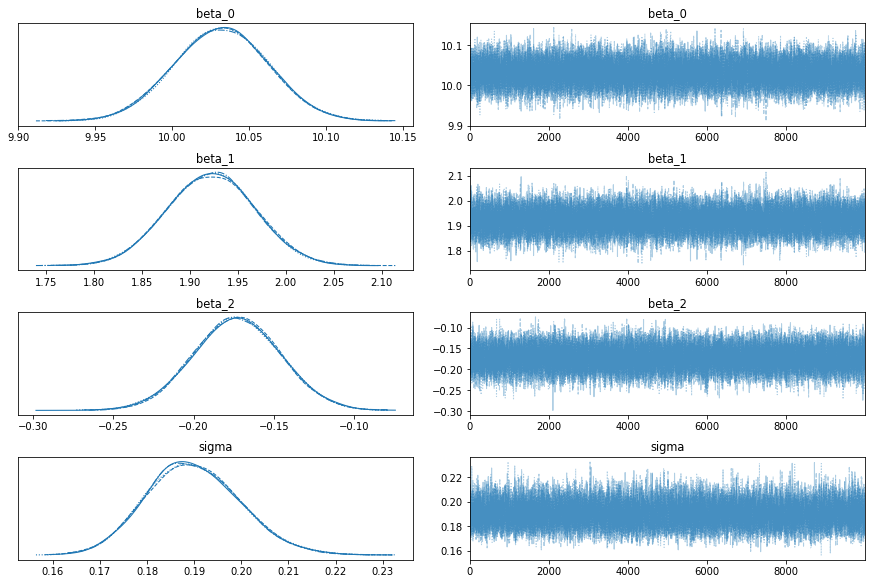

In [38]:
# Traceplot
with model:
    pm.plot_trace(trace, figsize=(16,16));

In [39]:
# exponentiate beta_2
coef = np.exp(trace["beta_2"])

In [40]:
# expected value for e^beta_2
np.mean(coef)

0.8414887989227238

In [43]:
100*(np.mean(coef)-1)
# Interpretation:
# if we are in class 1, we’d expect our wages to drop by 15.85 percent holding skill constant

-15.851120107727624

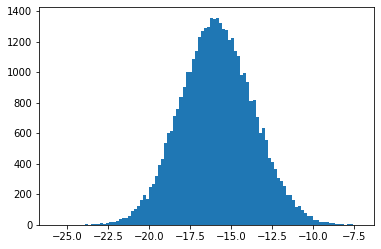

In [48]:
# View distribution of expected decrease in wages
plt.hist(100*(coef - 1), bins = 100);

In [58]:
100*(max(coef)-1)

-7.1906964679715575

### Compare to `statsmodels`.

In [32]:
import statsmodels.api as sm

X = wages[["skill", "class"]]
X = sm.add_constant(X)
y = np.log(wages["wage"])
lm = sm.OLS(y,X).fit()
lm.summary()

C:\Users\Andrew\Anaconda3\envs\pm3env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     936.5
Date:                Wed, 13 Oct 2021   Prob (F-statistic):          2.40e-101
Time:                        04:35:10   Log-Likelihood:                 50.782
No. Observations:                 200   AIC:                            -95.56
Df Residuals:                     197   BIC:                            -85.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0368      0.030    339.801      0.000       9.979      10.095
skill          1.9246      0.045     43.211      0.000       1.837       2.012
class         -0.1853      0.027     -6.890      0.000      -0.238      -0.132
==============================================================================
Omnibus:                       13.321   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.074
Skew:                          -0.152   Prob(JB):                     6.58e-08
Kurtosis:                       4.969   Cond. No.                         4.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# This was actually simulated to be 0.8
np.exp(-0.1853)

0.8308549899629231

In [34]:
100*(np.exp(-0.1853) - 1)
# Interpretation:
# if we are in class 1, we’d expect our wages to drop by 16.91 percent holding skill constant

-16.914501003707695